In [1]:
from platform import python_version
python_version()

'3.9.13'

# imports

In [84]:
import pandas as pd
import mlrose_hiive as mlrose
from scipy.io.arff import loadarff 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from copy import deepcopy
import numbers
import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

# tool funcs

## score per iter

In [73]:
def plot_learning_curve_loss_iter(loss, model_type, data_name, ylim=None):
    plt.figure()
    plt.plot(loss[2], loss[0], '-o', label='train')
    plt.plot(loss[2], loss[1], '-o', label='validation')
    if not ylim is None:
        plt.ylim(ylim[0], ylim[1])
    # plt.yscale('log')
    tick_step = loss[2][1] - loss[2][0]
    plt.xticks(range(min(loss[2]), max(loss[2])+tick_step, tick_step))
    plt.xlabel('Iteration')
    plt.ylabel('Loss (Cross-Entropy)')
    plt.title(f'{model_type} Learning Curve Loss vs. Iteration - {data_name}')
    plt.legend()
    plt.show()
def plot_learning_curve_f1_iter(f1, model_type, data_name, ylim=None):
    plt.figure()
    plt.plot(f1[2], f1[0], '-o', label='train')
    plt.plot(f1[2], f1[1], '-o', label='validation')
    if not ylim is None:
        plt.ylim(ylim[0], ylim[1])
    tick_step = f1[2][1] - f1[2][0]
    plt.xticks(range(min(f1[2]), max(f1[2])+tick_step, tick_step))
    plt.xlabel('Iteration')
    plt.ylabel('Performance (F1 Score)')
    plt.title(f'{model_type} Learning Curve Performance vs. Iteration - {data_name}')
    plt.legend()
    plt.show()

In [59]:
# copied from https://mlrose.readthedocs.io/en/latest/_modules/mlrose/neural.html#NeuralNetwork
def unflatten_weights(flat_weights, node_list):
    """
    Convert 1D weights array into list of 2D arrays.

    Parameters
    ----------
    flat_weights: array
        1D weights array.

    node_list: list
        List giving the number of nodes in each layer of the network,
        including the input and output layers.

    Returns
    -------
    weights: list of arrays
        List of 2D arrays created from flat_weights.
    """
    nodes = 0
    for i in range(len(node_list) - 1):
        nodes += node_list[i]*node_list[i + 1]

    if len(flat_weights) != nodes:
        raise Exception("""flat_weights must have length %d""" % (nodes,))

    weights = []
    start = 0

    for i in range(len(node_list) - 1):
        end = start + node_list[i]*node_list[i + 1]
        weights.append(np.reshape(flat_weights[start:end],
                                  [node_list[i], node_list[i+1]]))
        start = end

    return weights

def cal_loss(X, y, classifier):
    inputs_list = []
    weights = unflatten_weights(classifier.fitted_weights, classifier.node_list)
    # Add bias column to inputs matrix, if required
    ones = np.ones([np.shape(X)[0], 1])
    inputs = np.hstack((X, ones))

    # Pass data through network
    for i in range(len(weights)):
        # Multiple inputs by weights
        outputs = np.dot(inputs, weights[i])
        inputs_list.append(inputs)

        # Transform outputs to get inputs for next layer (or final preds)
        if i < len(weights) - 1:
            inputs = mlrose.neural.activation.relu(outputs)
        else:
            y_pred = mlrose.neural.activation.sigmoid(outputs)

    # Evaluate loss function
    # print(list(zip(y, y_pred)))
    fitness = log_loss(y, y_pred)
    return fitness

def mlrose_get_loss_per_iter(X_train_train, y_train_train, X_val, y_val, params):
    max_iters = params['max_iters']
    if max_iters >= 1000:
        step = max_iters//1000*100
    elif max_iters >= 500:
        step = 50
    elif max_iters >= 100:
        step = 20
    elif max_iters >= 20:
        step = 10
    else:
        step = 2
    params = deepcopy(params)
    del params['max_iters']
    loss_train_train_list = []
    loss_val_list = []
    f1_train_train_list=[]
    f1_val_list=[]
    iter_list = []
    for i in range(0,max_iters+1,step):
        classifier = mlrose.NeuralNetwork(**params, activation='relu', hidden_nodes=[20,20],
                                          max_iters=i, bias=True, is_classifier=True, 
                                          early_stopping=True, max_attempts=20, curve=False, random_state=0)
        np.random.seed(0)
        classifier.fit(X_train_train.values, y_train_train.values)
        loss_train_train = cal_loss(X_train_train, y_train_train, classifier)
        loss_train_train_list.append(loss_train_train)
        loss_val = cal_loss(X_val, y_val, classifier)
        loss_val_list.append(loss_val)
        iter_list.append(i)
        # f1
        pred_train_train = classifier.predict(X_train_train)
        f1_train_train=f1_score(y_train_train, pred_train_train, average="weighted")
        pred_val = classifier.predict(X_val)
        f1_val=f1_score(y_val, pred_val, average="weighted")
        f1_train_train_list.append(f1_train_train)
        f1_val_list.append(f1_val)
    return (loss_train_train_list, loss_val_list, iter_list), (f1_train_train_list, f1_val_list, iter_list)


## score per data percentage

## validation curve

In [5]:
def get_f1_avg(X_train, y_train, test_size, classifier):
    f1_train_train_list = []
    f1_val_list = []
    for random_state in range(10):
        X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, stratify=y_train)
        classifier.fit(X_train_train, y_train_train)
        pred_train_train = classifier.predict(X_train_train)
        f1_train_train=f1_score(y_train_train, pred_train_train, average="weighted")
        pred_val = classifier.predict(X_val)
        f1_val=f1_score(y_val, pred_val, average="weighted")
        f1_train_train_list.append(f1_train_train)
        f1_val_list.append(f1_val)   
    return np.mean(f1_train_train_list), np.mean(f1_val_list)

def get_f1_score_vs_train_pct(X_train, y_train, **params):
    f1_train_train_list=[]
    f1_val_list=[]
    thresh_pct_list=[]
    classifier = mlrose.NeuralNetwork(**params, activation='relu', hidden_nodes=[20,20],
                                      bias=True, is_classifier=True, 
                                          early_stopping=True, max_attempts=20, curve=False, random_state=0)
    for i in tqdm(range(1,10)):
        pct=i/10
        thresh_pct_list.append(i*10)
        f1_train_train, f1_val = get_f1_avg(X_train, y_train, test_size=1-pct, classifier=classifier)
        f1_train_train_list.append(f1_train_train)
        f1_val_list.append(f1_val)
    summary = pd.DataFrame({
        'f1_train': f1_train_train_list,
        'f1_val': f1_val_list,
        'train_pct': thresh_pct_list
    })   
    display(summary)
    return (f1_train_train_list, f1_val_list, thresh_pct_list)

def plot_learning_curve(f1, model_type, data_name):
    plt.figure()
    plt.plot(f1[2], f1[0], '--o', label='train')
    plt.plot(f1[2], f1[1], '--o', label='validation')
    plt.xticks(f1[2])
    plt.xlabel('Training Size (%)')
    plt.ylabel('Performance (F1 Score)')
    plt.title(f'{model_type} Learning Curve - {data_name}')
    plt.legend()
    plt.show()

In [6]:
def tune_hyper(X_train, y_train, classifier, param_grid):
    skfolds = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    search_f1 = GridSearchCV(classifier, param_grid, cv=skfolds, scoring='f1_weighted', return_train_score=True, n_jobs=-1)
    np.random.seed(0)
    search_f1.fit(X_train.values, y_train.values)
    best_classifier = search_f1.best_estimator_
    best_f1 = search_f1.best_score_
    best_params = search_f1.best_params_
    cv_result = pd.DataFrame(search_f1.cv_results_)
    print(f'Best classifier is {best_classifier} with f1 score {best_f1}')
    return best_params, cv_result

def plot_validation_curve(hyper, params, cv_result, model_type, data_name, hyper_name=None, hyper_list_name=None, log_x=False, rot_x=False):
    if hyper_name is None:
        hyper_name = hyper
    cv_result_hyper = cv_result.copy()
    change_ticks = False
    for param in params:
        if param != hyper:
            cv_result_hyper = cv_result_hyper[cv_result_hyper[f'param_{param}']==params[param]]
    hyper_list = cv_result_hyper[f'param_{hyper}']
    f1_train_list = cv_result_hyper['mean_train_score']
    f1_val_list = cv_result_hyper['mean_test_score']
    if not isinstance(list(hyper_list)[0], numbers.Number):
        change_ticks = True
        if hyper_list_name is not None:
            tick_label_list = hyper_list_name
        else:
            tick_label_list = hyper_list
        hyper_list = list(range(len(hyper_list)))
    plt.plot(hyper_list, f1_train_list, '--o', label='train')
    plt.plot(hyper_list, f1_val_list, '--o', label='validation')
    if log_x:
        plt.xscale('log')
    if change_ticks:
        rotation = 0
        if rot_x == True:
            rotation = 45
        plt.xticks(hyper_list, tick_label_list, rotation=rotation)
    plt.xlabel(f'{hyper_name}')
    plt.ylabel('Performance (F1 Score)')
    plt.legend()
    plt.title(f'{model_type} Validation Curve  - {data_name}')
    plt.show()

## model performance

In [7]:
def model_performance(X_train, y_train, X_test, y_test, classifier, model_type, data_name):
    start_t = time.time()
    np.random.seed(1)
    classifier.fit(X_train, y_train)
    train_t = round(time.time() - start_t, 4)
    start_t = time.time()
    for i in range(100):
        pred_test = classifier.predict(X_test)
    pred_t = round((time.time() - start_t)/100, 4)
    pred_train = classifier.predict(X_train)
    print('Test performance:')
    print(classification_report(y_test, pred_test))
    cm = confusion_matrix(y_test, pred_test, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.title(f'{model_type} - {data_name} - Test')
    plt.show()
    print('Train performance:')
    print(classification_report(y_train, pred_train))
    cm = confusion_matrix(y_train, pred_train, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.title(f'{model_type} - {data_name} - Train')
    plt.show()
    print(f'Train time is {train_t} seconds.')
    print(f'Prediction time is {pred_t} seconds.')
    return train_t, pred_t

In [8]:
def model_f1(classifier, X_train, y_train, X_test, y_test):
    np.random.seed(1)
    classifier.fit(X_train, y_train)
    pred_train = classifier.predict(X_train)
    pred_test = classifier.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average="weighted")
    f1_test = f1_score(y_test, pred_test, average="weighted")
    return f1_train, f1_test
def all_model_f1_1(X_train, y_train, X_test, y_test):
    f1_train_ls = []
    f1_test_ls = []
    for clf in [best_gd_classifier1, best_rhc_classifier1, best_sa_classifier1, best_ga_classifier1]:
        f1_train, f1_test = model_f1(clf, X_train, y_train, X_test, y_test)
        f1_train_ls.append(f1_train)
        f1_test_ls.append(f1_test)
    return f1_train_ls, f1_test_ls

# read data

In [9]:
data1_name = 'Telescope'
raw_data1 = loadarff('MagicTelescope.arff')
data1 = pd.DataFrame(raw_data1[0])
data1 = data1.drop(columns=['ID'])
data1 = data1.rename(columns=lambda x: x.replace(':', ''))
data1['class'] = data1['class'].str.decode('utf-8')
data1 = pd.concat([
    data1[data1['class']=='g'].sample(510, random_state=0),
    data1[data1['class']=='h'].sample(490, random_state=0)])
data1.index = range(len(data1))
data1

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,69.2979,26.8809,3.1930,0.2065,0.1074,39.6296,44.3457,-23.0604,9.3234,248.7500,g
1,24.5939,10.1418,2.5676,0.5007,0.2693,-8.4503,15.2452,-7.0283,17.0056,173.2880,g
2,55.4800,27.1606,3.1826,0.2299,0.1225,43.1016,54.2556,13.7406,32.2220,262.1810,g
3,12.6594,11.7413,2.1351,0.7033,0.3846,-15.8596,9.4522,-8.7126,43.5434,227.7110,g
4,38.6204,20.5632,2.9770,0.2478,0.1270,-13.8229,-31.3983,-13.1337,5.8671,192.4670,g
...,...,...,...,...,...,...,...,...,...,...,...
995,17.5875,15.8431,2.5563,0.5889,0.4069,-4.9856,-8.9744,6.0916,27.3912,98.9112,h
996,51.5102,10.0816,2.8742,0.3848,0.2265,21.7655,28.1719,8.0106,45.8060,163.5740,h
997,60.5159,13.5790,3.0125,0.3476,0.2103,61.5637,60.1913,5.2105,2.8626,247.4307,h
998,13.4287,12.5724,2.5091,0.4125,0.2284,11.3890,13.6556,1.7479,51.2221,174.8656,h


In [10]:
X1=data1.drop(columns=['class'])
y1=data1['class'].map({'g':1, 'h':0})
min_max_scaler = MinMaxScaler()
X1_scaled = min_max_scaler.fit_transform(X1)
X1_scaled = pd.DataFrame(X1_scaled, columns=X1.columns)
print(y1.value_counts())

1    510
0    490
Name: class, dtype: int64


## split data

In [11]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.3, random_state=0, stratify=y1)
X1_train_train, X1_val, y1_train_train, y1_val = train_test_split(X1_train, y1_train, test_size=0.2, random_state=0, stratify=y1_train)

# sklearn model

In [12]:
# def get_loss_per_iter(X_train_train, y_train_train, X_val, y_val, params):
#     loss_train_train_list = []
#     loss_val_list = []
#     iter_list = []
#     classifier = MLPClassifier(**params, warm_start=True, max_iter=50, random_state=0)
#     for i in range(0,800,50):
#         np.random.seed(0)
#         classifier.fit(X_train_train.values, y_train_train.values)
#         pred_train_train = classifier.predict_proba(X_train_train.values)
#         loss_train_train = log_loss(y_train_train, pred_train_train)
#         loss_train_train_list.append(loss_train_train)
#         pred_val = classifier.predict_proba(X_val.values)
#         loss_val = log_loss(y_val, pred_val)
#         loss_val_list.append(loss_val)
#         iter_list.append(i)
#     return loss_train_train_list, loss_val_list, iter_list

In [13]:
# def plot_learning_curve_loss_iter(loss, model_type, data_name):
#     plt.plot(loss[2], loss[0], '-o', label='train')
#     plt.plot(loss[2], loss[1], '-o', label='validation')
#     tick_step = 50
#     plt.xticks(range(min(loss[2]), max(loss[2])+tick_step, tick_step))
#     plt.xlabel('Iteration')
#     plt.ylabel('Loss (Cross-Entropy)')
#     plt.title(f'{model_type} Learning Curve Loss vs. Iteration - {data_name}')
#     plt.legend()
#     plt.show()

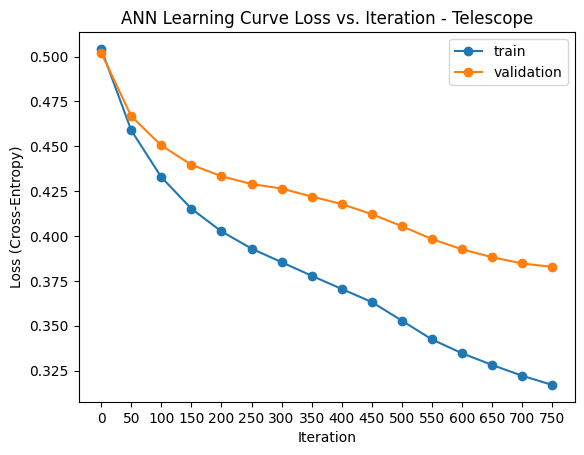

In [14]:
params1 = {
    # 'alpha': 0.005, 
    'hidden_layer_sizes': (20, 20), 
    'learning_rate_init': 0.001
}
loss1 = get_loss_per_iter(X1_train_train, y1_train_train, X1_val, y1_val, params1)
plot_learning_curve_loss_iter(loss1, model_type='ANN', data_name=data1_name)


# gradient descent

In mlrose, fitness function is log_loss (Cross Entropy) for classification problems.

## tune hyper

Best classifier is NeuralNetwork(algorithm='gradient_descent', clip_max=10000, early_stopping=True,
              hidden_nodes=[20, 20], learning_rate=0.001, max_attempts=100,
              max_iters=3000, random_state=0) with f1 score 0.8339698075389332


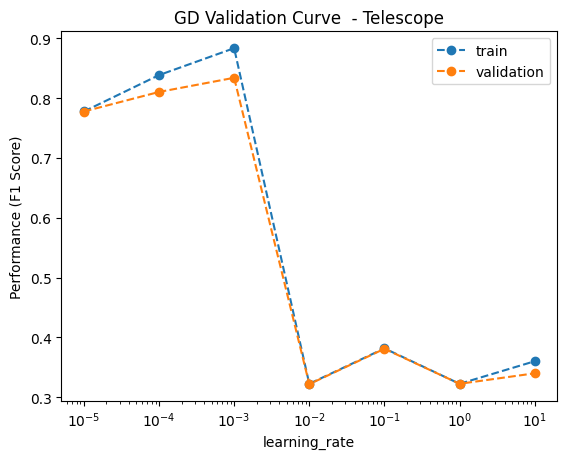

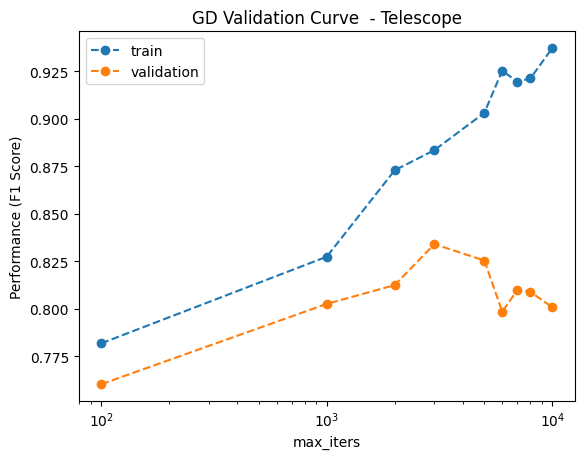

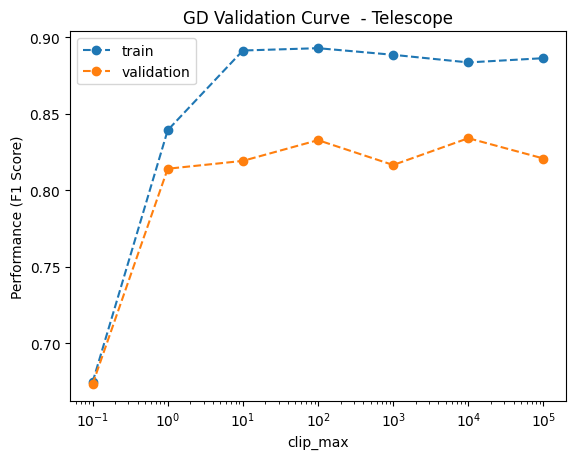

CPU times: user 14min 20s, sys: 28.1 s, total: 14min 48s
Wall time: 21min 10s


In [106]:
%%time
# random_state doesn't guarantee repeatable results
classifier = mlrose.NeuralNetwork(bias=True, is_classifier=True, activation='relu',
                                  hidden_nodes=[20,20], early_stopping=True, max_attempts=100, 
                                  curve=False, random_state=0)
param_grid = {
    'algorithm': ['gradient_descent'],
    'learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'max_iters': [100, 1000, 2000, 3000, 5000, 6000, 7000, 8000, 10000],
    'clip_max': [0.1, 1, 10, 100, 1000, 10000, 100000]
}
best_gd_params1, gd_cv_result1 = tune_hyper(X1_train, y1_train, classifier, param_grid)
model_type = 'GD'
hyper = 'learning_rate'
plot_validation_curve(hyper, params=best_gd_params1, cv_result=gd_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)
hyper = 'max_iters'
plot_validation_curve(hyper, params=best_gd_params1, cv_result=gd_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)
hyper = 'clip_max'
plot_validation_curve(hyper, params=best_gd_params1, cv_result=gd_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)

## learning curve -- iter

In [12]:
# best_gd_params1 = {
#     'algorithm': 'gradient_descent',
#     'learning_rate': 0.001,
#     'max_iters': 3000,
#     'clip_max': 10000
# }

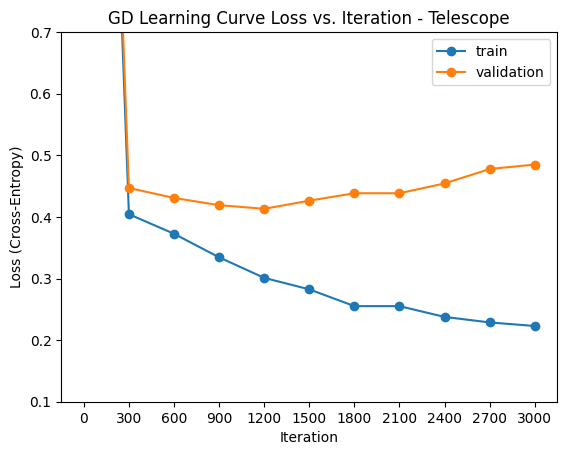

CPU times: user 222 ms, sys: 7.74 ms, total: 229 ms
Wall time: 90.7 ms


In [115]:
%%time
best_gd_params1 = {
    'algorithm': 'gradient_descent',
    'learning_rate': 0.001,
    'max_iters': 3000,
    'clip_max': 10000
}
gd_loss1, gd_f1_1 = mlrose_get_loss_per_iter(X1_train_train, y1_train_train, X1_val, y1_val, best_gd_params1)
plot_learning_curve_loss_iter(gd_loss1, ylim=(0.1, 0.7), model_type='GD', data_name=data1_name)

## learning curve -- data percentage

100%|████████████████████████████████████████████████████| 9/9 [19:49<00:00, 132.19s/it]


,f1_train,f1_val,train_pct
0,0.905497,0.766236,10
1,0.899866,0.777413,20
2,0.916614,0.792025,30
3,0.914870,0.784812,40
4,0.906728,0.796609,50
5,0.903980,0.801380,60
6,0.897301,0.801691,70
7,0.884381,0.810907,80
8,0.879933,0.808096,90


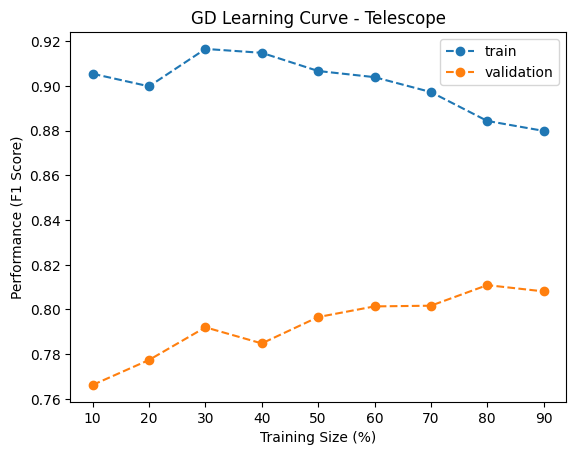

CPU times: user 1h 36min 21s, sys: 15min 47s, total: 1h 52min 9s
Wall time: 19min 49s


In [116]:
%%time
gd_data_f1_1 = get_f1_score_vs_train_pct(X1_train, y1_train, **best_gd_params1)
plot_learning_curve(gd_data_f1_1, model_type='GD', data_name=data1_name)

## model performance

Test performance:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       147
           1       0.79      0.84      0.82       153

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



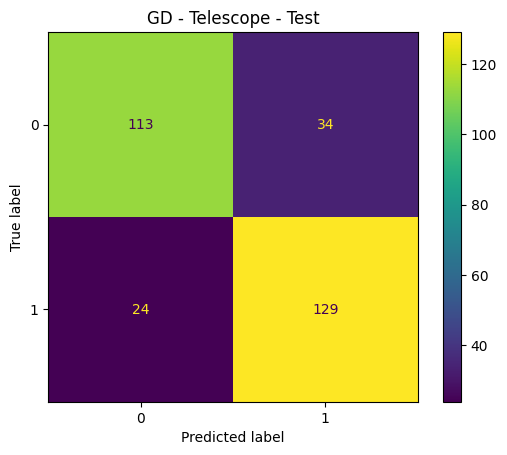

Train performance:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       343
           1       0.86      0.90      0.88       357

    accuracy                           0.88       700
   macro avg       0.88      0.88      0.88       700
weighted avg       0.88      0.88      0.88       700



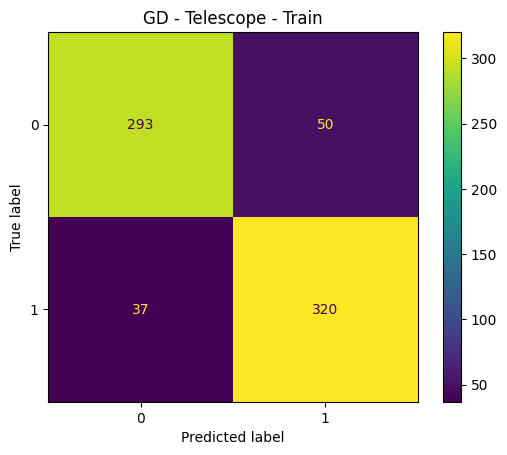

Train time is 45.1023 seconds.
Prediction time is 0.0002 seconds.
CPU times: user 5min 14s, sys: 3.67 s, total: 5min 17s
Wall time: 45.4 s


In [14]:
%%time
best_gd_classifier1 = mlrose.NeuralNetwork(**best_gd_params1, activation='relu', hidden_nodes=[20,20],
                                      bias=True, is_classifier=True, 
                                          early_stopping=True, max_attempts=100, curve=False, random_state=0)
gd_train_t1, gd_pred_t1 = model_performance(X1_train, y1_train, X1_test, y1_test, best_gd_classifier1, model_type='GD', 
                                                data_name=data1_name)

# random hill climbing

In [19]:
# %%time
# grid_search_parameters = {   
#     'learning_rate': [0.001, 0.01, 0.1, 1, 5, 10],
#     'activation': [mlrose.neural.activation.relu],
#     'scoring':['f1_weighted'],
#     'max_iters': [100],
#     'restart': [5, 10]
# }
# rhc_nnr = mlrose.NNGSRunner(x_train=X1_train_train,
#                      y_train=y1_train_train,
#                      x_test=X1_val,
#                      y_test=y1_val,
#                      experiment_name='nn_gd',
#                      algorithm=mlrose.random_hill_climb,
#                      grid_search_parameters=grid_search_parameters,
#                      grid_search_scorer_method=f1_score,
#                      iteration_list=range(0,4000+1,400),
#                      hidden_layer_sizes=[[20,20]],
#                      bias=True,
#                      early_stopping=True,
#                      max_attempts=20,
#                      generate_curves=True,
#                      seed=0)
# rhc_results = rhc_nnr.run()

In [20]:
# best_rhc_params1 = deepcopy(rhc_nnr.best_params)
# del best_rhc_params1['hidden_layer_sizes']
# del best_rhc_params1['scoring']
# del best_rhc_params1['activation']
# model_type = 'RHC'
# hyper = 'learning_rate'
# plot_validation_curve(hyper, params=best_rhc_params1, cv_result=rhc_results[2], 
#                       model_type=model_type, data_name=data1_name, log_x=True)

## tune hyper

Best classifier is NeuralNetwork(early_stopping=True, hidden_nodes=[20, 20], learning_rate=1,
              max_attempts=100, max_iters=3000, random_state=0, restarts=100) with f1 score 0.8136997776999172


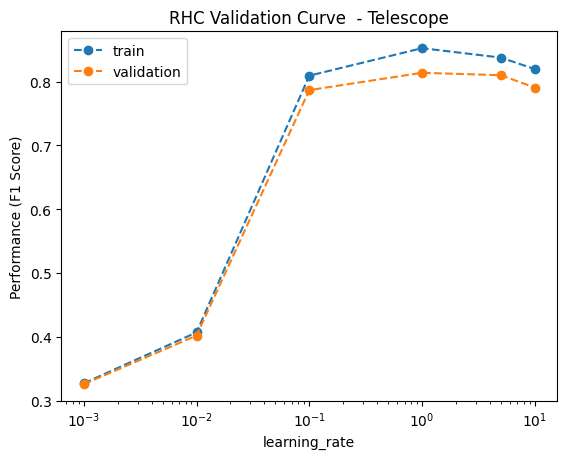

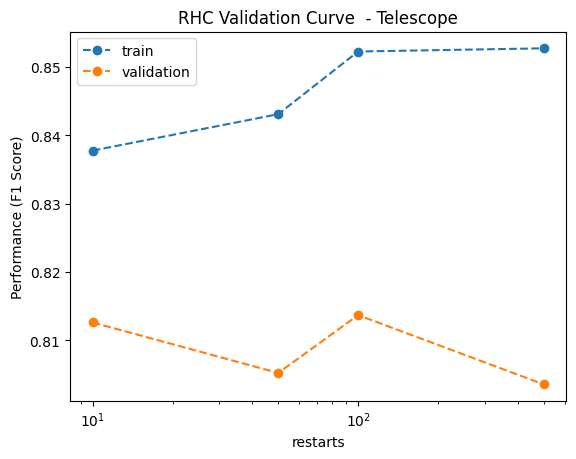

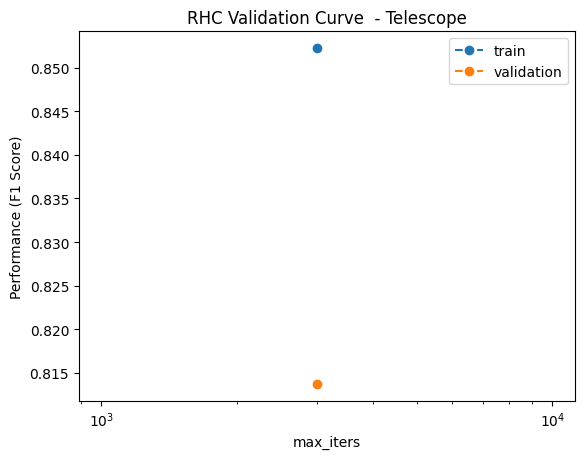

CPU times: user 44min 10s, sys: 1min 3s, total: 45min 14s
Wall time: 1h 38min 7s


In [118]:
%%time
# random_state doesn't guarantee repeatable results
classifier = mlrose.NeuralNetwork(hidden_nodes=[20,20], activation='relu',
                                  bias=True, is_classifier=True, 
                                  early_stopping=True, max_attempts=100, 
                                  curve=False, random_state=0)
param_grid = {
    'algorithm': ['random_hill_climb'],
    'learning_rate': [0.001, 0.01, 0.1, 1, 5, 10],
    'restarts': [10, 50, 100, 500],
    'max_iters': [3000],
    'clip_max': [10000]
}
best_rhc_params1, rhc_cv_result1 = tune_hyper(X1_train, y1_train, classifier, param_grid)
model_type = 'RHC'
hyper = 'learning_rate'
plot_validation_curve(hyper, params=best_rhc_params1, cv_result=rhc_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)
hyper = 'restarts'
plot_validation_curve(hyper, params=best_rhc_params1, cv_result=rhc_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)
hyper = 'max_iters'
plot_validation_curve(hyper, params=best_rhc_params1, cv_result=rhc_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)

## learning curve -- iter

In [15]:
# best_rhc_params1 = {
#     'algorithm': 'random_hill_climb',
#     'learning_rate': 1,
#     'max_iters': 3000,
#     'restarts': 100
# }

In [121]:
best_rhc_params1

{'algorithm': 'random_hill_climb',
 'learning_rate': 1,
 'max_iters': 3000,
 'restarts': 100}

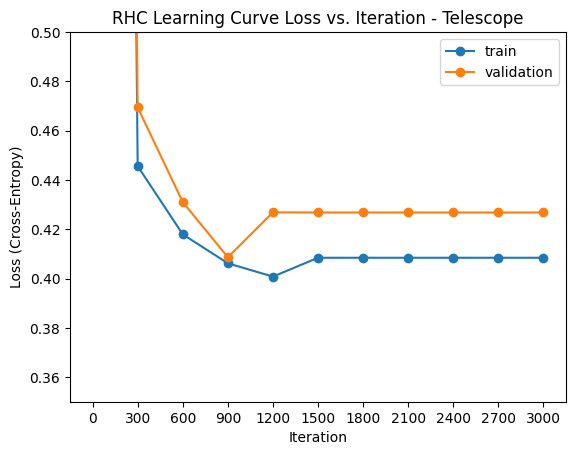

CPU times: user 248 ms, sys: 6.56 ms, total: 255 ms
Wall time: 97.3 ms


In [123]:
%%time
rhc_loss1, rhc_f1_1 = mlrose_get_loss_per_iter(X1_train_train, y1_train_train, X1_val, y1_val, best_rhc_params1)
plot_learning_curve_loss_iter(rhc_loss1, ylim=(0.35, 0.5), model_type='RHC', data_name=data1_name)
# plot_learning_curve_f1_iter(rhc_f1_1, ylim=(0.7, 0.9), model_type='RHC', data_name=data1_name)

## learning curve -- data percentage

100%|██████████████████████████████████████████████████| 9/9 [1:28:37<00:00, 590.87s/it]


,f1_train,f1_val,train_pct
0,0.856837,0.763148,10
1,0.826004,0.765177,20
2,0.805751,0.771616,30
3,0.816393,0.783345,40
4,0.815212,0.793271,50
5,0.812100,0.795147,60
6,0.812045,0.792365,70
7,0.810662,0.785653,80
8,0.805198,0.787738,90


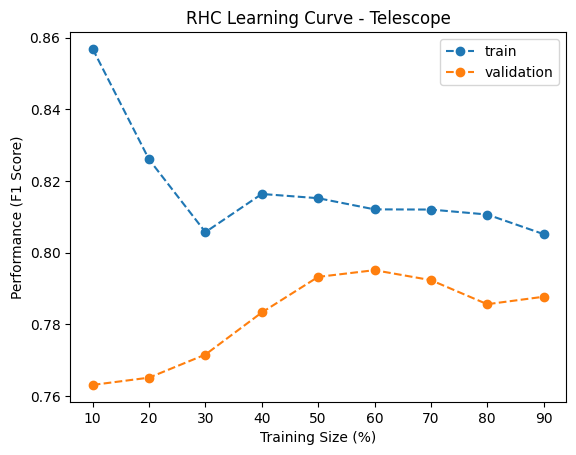

CPU times: user 6h 57min 47s, sys: 1h 11min 25s, total: 8h 9min 12s
Wall time: 1h 28min 37s


In [124]:
%%time
rhc_data_f1_1 = get_f1_score_vs_train_pct(X1_train, y1_train, **best_rhc_params1)
plot_learning_curve(rhc_data_f1_1, model_type='RHC', data_name=data1_name)

## model performance

Test performance:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       147
           1       0.81      0.82      0.81       153

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



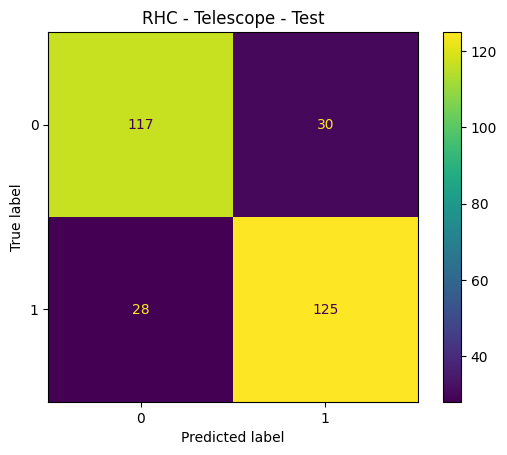

Train performance:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       343
           1       0.84      0.87      0.85       357

    accuracy                           0.85       700
   macro avg       0.85      0.85      0.85       700
weighted avg       0.85      0.85      0.85       700



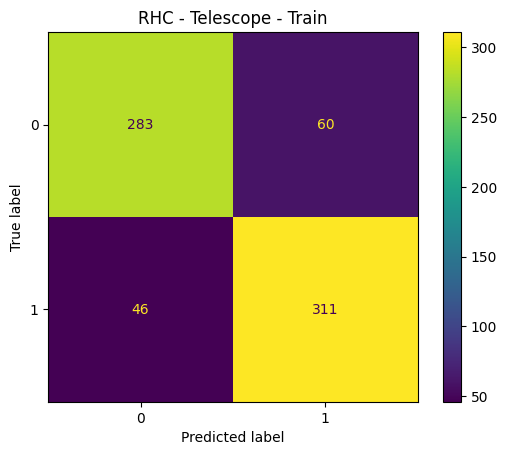

Train time is 2754.4933 seconds.
Prediction time is 0.0002 seconds.
CPU times: user 4h 53min 11s, sys: 6min 14s, total: 4h 59min 25s
Wall time: 45min 54s


In [16]:
%%time
best_rhc_classifier1 = mlrose.NeuralNetwork(**best_rhc_params1, activation='relu', hidden_nodes=[20,20],
                                      bias=True, is_classifier=True, 
                                          early_stopping=True, max_attempts=100, curve=False, random_state=0)
rhc_train_t1, rhc_pred_t1 = model_performance(X1_train, y1_train, X1_test, y1_test, best_rhc_classifier1, model_type='RHC', 
                                                data_name=data1_name)

In [128]:
np.min(best_gd_classifier1.fitted_weights)

-6.288990930481144

In [18]:
np.max(best_rhc_classifier1.fitted_weights)

3.703343749872734

In [17]:
np.max(best_ga_classifier1.fitted_weights)

NameError: name 'best_ga_classifier1' is not defined

# simulated annealing

## tune hyper

Best classifier is NeuralNetwork(algorithm='simulated_annealing', early_stopping=True,
              hidden_nodes=[20, 20], learning_rate=1, max_attempts=20,
              max_iters=3000, random_state=0,
              schedule=GeomDecay(init_temp=1, decay=0.99, min_temp=0.001)) with f1 score 0.8110811593766971


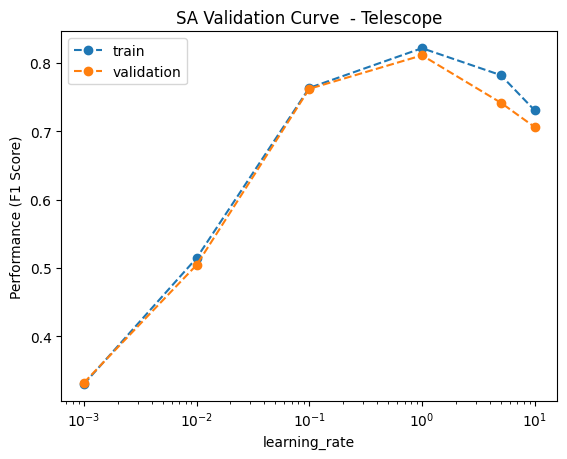

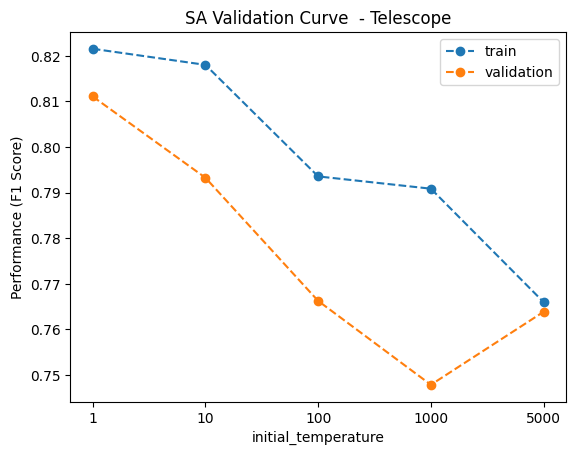

CPU times: user 27.5 s, sys: 2.02 s, total: 29.5 s
Wall time: 55.9 s


In [119]:
%%time
# random_state doesn't guarantee repeatable results
classifier = mlrose.NeuralNetwork(hidden_nodes=[20,20], activation='relu',
                                  bias=True, is_classifier=True, 
                                  early_stopping=True, max_attempts=100, 
                                  curve=False, random_state=0)
param_grid = {
    'algorithm': ['simulated_annealing'],
    'learning_rate': [0.001, 0.01, 0.1, 1, 5, 10],
    'schedule': [
        mlrose.GeomDecay(init_temp=1),
        mlrose.GeomDecay(init_temp=10),
        mlrose.GeomDecay(init_temp=100),
        mlrose.GeomDecay(init_temp=1000),
        mlrose.GeomDecay(init_temp=5000),
    ],
    'max_iters': [3000],
    'clip_max': [10000]
}
best_sa_params1, sa_cv_result1 = tune_hyper(X1_train, y1_train, classifier, param_grid)
model_type = 'SA'
hyper = 'learning_rate'
plot_validation_curve(hyper,params=best_sa_params1, cv_result=sa_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)
hyper = 'schedule'
plot_validation_curve(hyper, hyper_name='initial_temperature', hyper_list_name=[1,10,100,1000,5000], params=best_sa_params1, cv_result=sa_cv_result1, 
                      model_type=model_type, data_name=data1_name)

## learning curve -- iter

In [19]:
# best_sa_params1 = {
#     'algorithm': 'simulated_annealing',
#  'learning_rate': 1,
#  'max_iters': 3000,
#  'schedule': mlrose.GeomDecay(init_temp=1)
# }

In [132]:
best_sa_params1

{'algorithm': 'simulated_annealing',
 'learning_rate': 1,
 'max_iters': 3000,
 'schedule': GeomDecay(init_temp=1, decay=0.99, min_temp=0.001)}

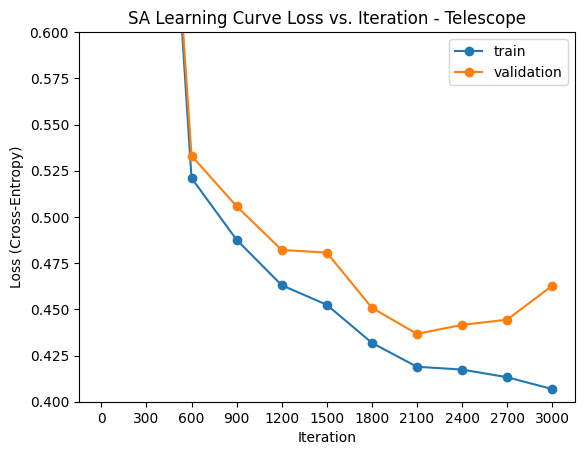

CPU times: user 296 ms, sys: 9.75 ms, total: 306 ms
Wall time: 120 ms


In [137]:
%%time
sa_loss1, sa_f1_1 = mlrose_get_loss_per_iter(X1_train_train, y1_train_train, X1_val, y1_val, 
                                             best_sa_params1)
plot_learning_curve_loss_iter(sa_loss1, ylim=(0.4, 0.6), model_type='SA', data_name=data1_name)
# plot_learning_curve_f1_iter(sa_f1_1, model_type='SA', data_name=data1_name)

## learning curve -- data percentage

100%|████████████████████████████████████████████████████| 9/9 [15:06<00:00, 100.69s/it]


,f1_train,f1_val,train_pct
0,0.892459,0.730427,10
1,0.864083,0.761263,20
2,0.835022,0.774068,30
3,0.837298,0.782309,40
4,0.820081,0.776045,50
5,0.823429,0.796090,60
6,0.822497,0.791590,70
7,0.810730,0.794017,80
8,0.816463,0.803541,90


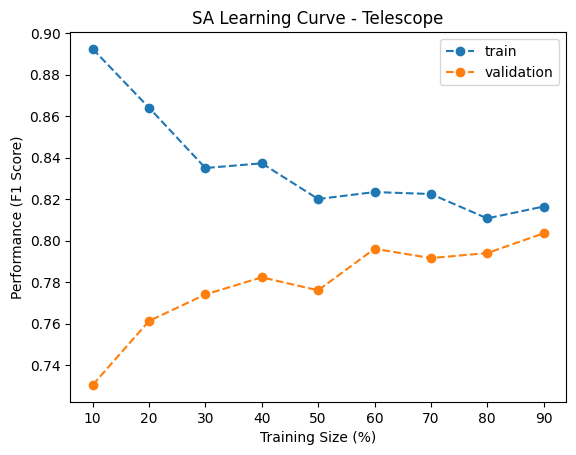

CPU times: user 1h 7min 34s, sys: 10min 32s, total: 1h 18min 7s
Wall time: 15min 6s


In [138]:
%%time
sa_data_f1_1 = get_f1_score_vs_train_pct(X1_train, y1_train, **best_sa_params1)
plot_learning_curve(sa_data_f1_1, model_type='SA', data_name=data1_name)

## model performance

Test performance:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       147
           1       0.78      0.79      0.78       153

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300



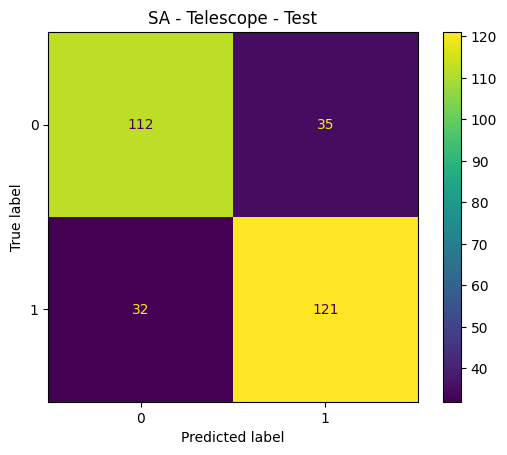

Train performance:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       343
           1       0.82      0.84      0.83       357

    accuracy                           0.83       700
   macro avg       0.83      0.83      0.83       700
weighted avg       0.83      0.83      0.83       700



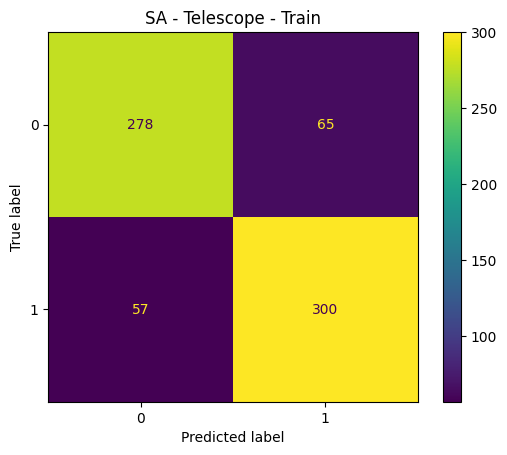

Train time is 26.6621 seconds.
Prediction time is 0.0002 seconds.


In [20]:
best_sa_classifier1 = mlrose.NeuralNetwork(**best_sa_params1, activation='relu', hidden_nodes=[20,20],
                                      bias=True, is_classifier=True, 
                                          early_stopping=True, max_attempts=100, curve=False, random_state=0)
sa_train_t1, sa_pred_t1 = model_performance(X1_train, y1_train, X1_test, y1_test, best_sa_classifier1, model_type='SA', 
                                                data_name=data1_name)

Test performance:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       147
           1       0.78      0.79      0.78       153

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300



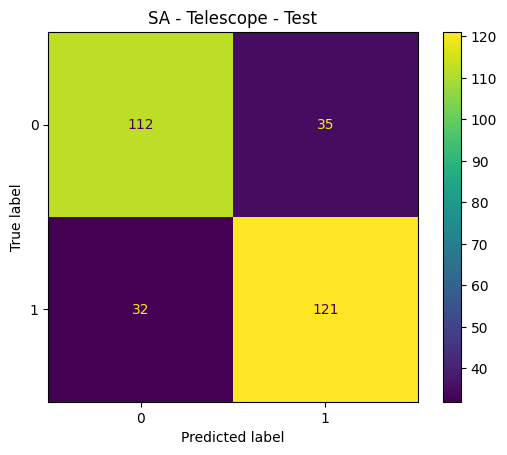

Train performance:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       343
           1       0.82      0.84      0.83       357

    accuracy                           0.83       700
   macro avg       0.83      0.83      0.83       700
weighted avg       0.83      0.83      0.83       700



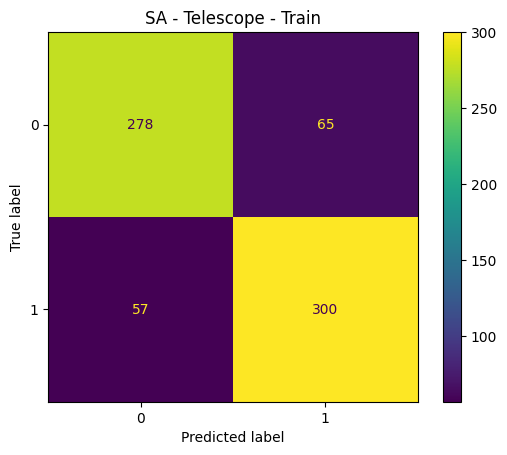

Train time is 81.0371 seconds.
Prediction time is 0.0001 seconds.


In [139]:
best_sa_classifier1 = mlrose.NeuralNetwork(**best_sa_params1, activation='relu', hidden_nodes=[20,20],
                                      bias=True, is_classifier=True, 
                                          early_stopping=True, max_attempts=20, curve=False, random_state=0)
sa_train_t1, sa_pred_t1 = model_performance(X1_train, y1_train, X1_test, y1_test, best_sa_classifier1, model_type='SA', 
                                                data_name=data1_name)

# genetic algorithm

## tune hyper

Best classifier is NeuralNetwork(algorithm='genetic_alg', clip_max=10000, early_stopping=True,
              hidden_nodes=[20, 20], learning_rate=1, max_attempts=100,
              max_iters=3000, mutation_prob=0.6, pop_size=500, random_state=0) with f1 score 0.7735409644911699


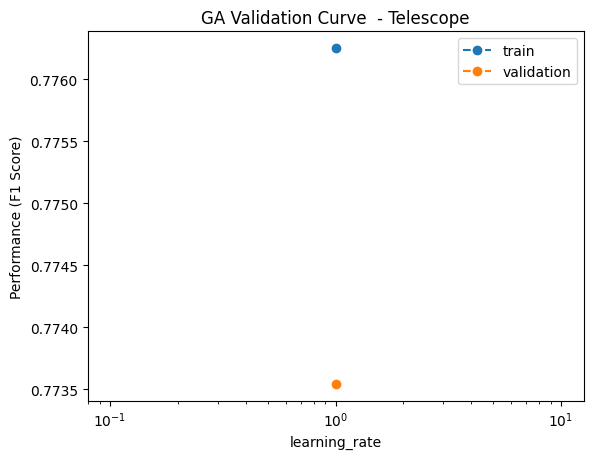

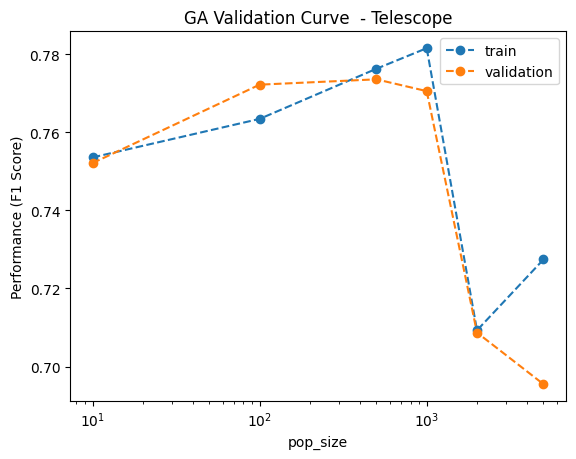

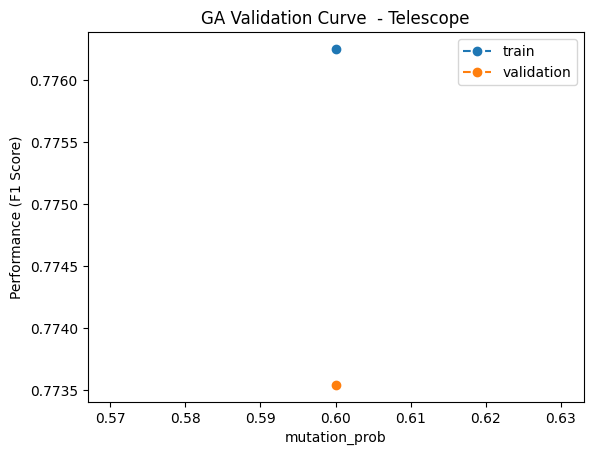

CPU times: user 1h 42min 11s, sys: 4min 37s, total: 1h 46min 48s
Wall time: 38min 43s


In [22]:
%%time
# random_state doesn't guarantee repeatable results
classifier = mlrose.NeuralNetwork(hidden_nodes=[20,20], activation='relu',
                                  bias=True, is_classifier=True, 
                                  early_stopping=True, max_attempts=100, 
                                  curve=False, random_state=0)
param_grid = {
    'algorithm': ['genetic_alg'],
    'learning_rate': [1],
    'pop_size': [10, 100, 500, 1000, 2000, 5000],
    'mutation_prob': [0.6],
    'max_iters': [3000],
    'clip_max': [10000]
}
best_ga_params1, ga_cv_result1 = tune_hyper(X1_train, y1_train, classifier, param_grid)
model_type = 'GA'
hyper = 'learning_rate'
plot_validation_curve(hyper, params=best_ga_params1, cv_result=ga_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)
hyper = 'pop_size'
plot_validation_curve(hyper, params=best_ga_params1, cv_result=ga_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)
hyper = 'mutation_prob'
plot_validation_curve(hyper, params=best_ga_params1, cv_result=ga_cv_result1, 
                      model_type=model_type, data_name=data1_name)

Best classifier is NeuralNetwork(algorithm='genetic_alg', clip_max=10000, early_stopping=True,
              hidden_nodes=[20, 20], learning_rate=1, max_attempts=100,
              max_iters=3000, mutation_prob=0.4, pop_size=500, random_state=0) with f1 score 0.7751119620727674


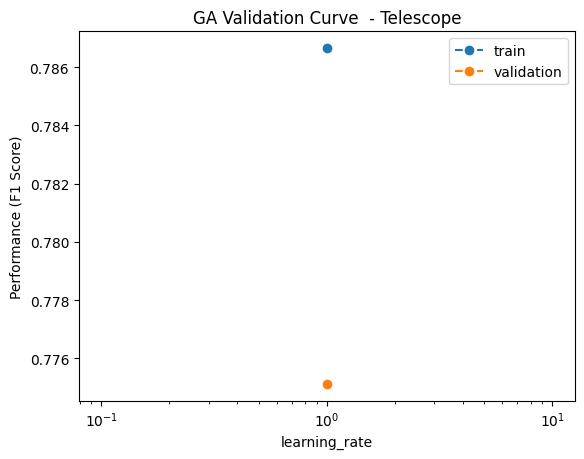

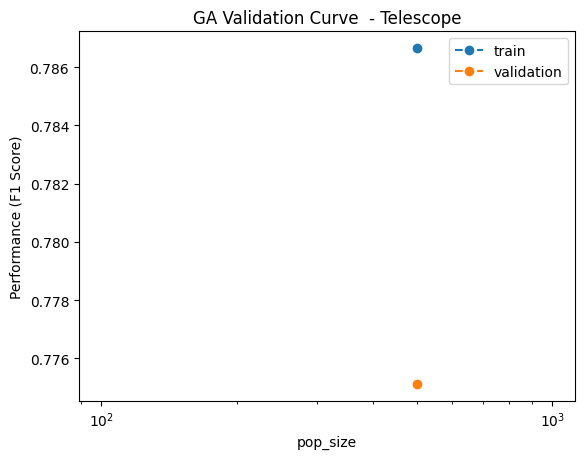

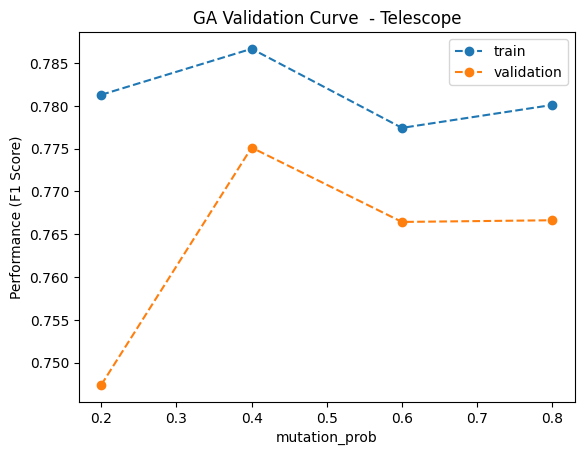

CPU times: user 1h 3min 17s, sys: 4min 31s, total: 1h 7min 49s
Wall time: 14min 5s


In [23]:
%%time
# random_state doesn't guarantee repeatable results
classifier = mlrose.NeuralNetwork(hidden_nodes=[20,20], activation='relu',
                                  bias=True, is_classifier=True, 
                                  early_stopping=True, max_attempts=100, 
                                  curve=False, random_state=0)
param_grid = {
    'algorithm': ['genetic_alg'],
    'learning_rate': [1],
    'pop_size': [500],
    'mutation_prob': [0.2, 0.4, 0.6, 0.8],
    'max_iters': [3000],
    'clip_max': [10000]
}
best_ga_params1, ga_cv_result1 = tune_hyper(X1_train, y1_train, classifier, param_grid)
model_type = 'GA'
hyper = 'learning_rate'
plot_validation_curve(hyper, params=best_ga_params1, cv_result=ga_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)
hyper = 'pop_size'
plot_validation_curve(hyper, params=best_ga_params1, cv_result=ga_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)
hyper = 'mutation_prob'
plot_validation_curve(hyper, params=best_ga_params1, cv_result=ga_cv_result1, 
                      model_type=model_type, data_name=data1_name)

Best classifier is NeuralNetwork(algorithm='genetic_alg', early_stopping=True,
              hidden_nodes=[20, 20], learning_rate=1, max_attempts=20,
              max_iters=3000, mutation_prob=0.6, pop_size=500, random_state=0) with f1 score 0.7852035948254953


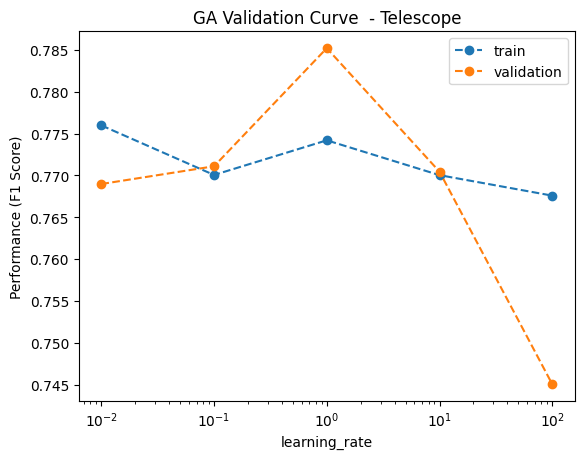

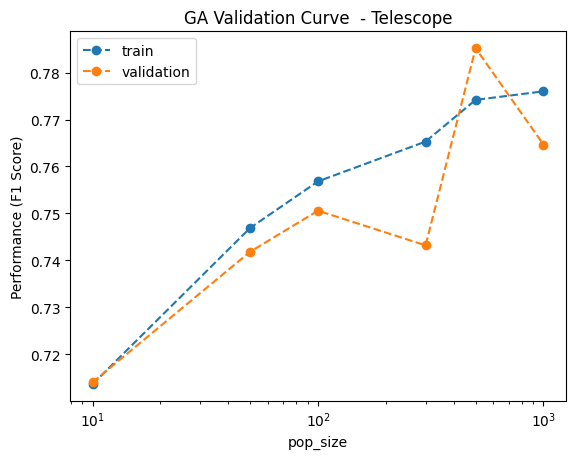

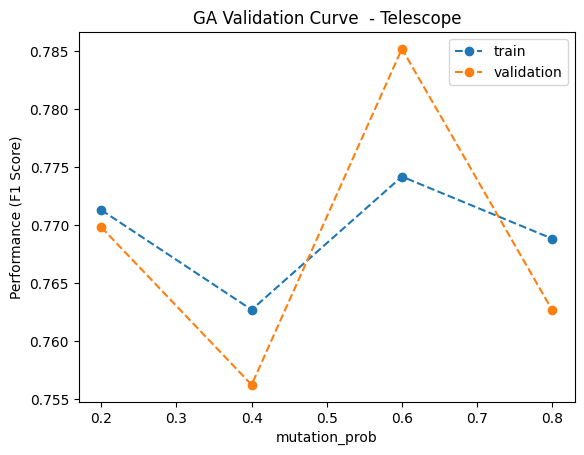

CPU times: user 3min 30s, sys: 1min 2s, total: 4min 33s
Wall time: 14min 13s


In [120]:
%%time
# random_state doesn't guarantee repeatable results
classifier = mlrose.NeuralNetwork(hidden_nodes=[20,20], activation='relu',
                                  bias=True, is_classifier=True, 
                                  early_stopping=True, max_attempts=20, 
                                  curve=False, random_state=0)
param_grid = {
    'algorithm': ['genetic_alg'],
    'learning_rate': [0.01, 0.1, 1, 10, 100],
    'pop_size': [10, 50, 100, 300, 500, 1000],
    'mutation_prob': [0.2, 0.4, 0.6, 0.8],
    'max_iters': [3000],
    'clip_max': [10000]
}
best_ga_params1, ga_cv_result1 = tune_hyper(X1_train, y1_train, classifier, param_grid)
model_type = 'GA'
hyper = 'learning_rate'
plot_validation_curve(hyper, params=best_ga_params1, cv_result=ga_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)
hyper = 'pop_size'
plot_validation_curve(hyper, params=best_ga_params1, cv_result=ga_cv_result1, 
                      model_type=model_type, data_name=data1_name, log_x=True)
hyper = 'mutation_prob'
plot_validation_curve(hyper, params=best_ga_params1, cv_result=ga_cv_result1, 
                      model_type=model_type, data_name=data1_name)

## learning curve -- iter

In [24]:
best_ga_params1 = {
    'algorithm': 'genetic_alg',
 'learning_rate': 1,
 'max_iters': 3000,
 'mutation_prob': 0.4,
 'pop_size': 500
}

In [75]:
best_ga_params1 = {
    'algorithm': 'genetic_alg',
 'learning_rate': 1, # 0.01
 'max_iters': 10,
 'mutation_prob': 0.4,
 'pop_size': 500,
    'clip_max':10
}

In [140]:
best_ga_params1

{'algorithm': 'genetic_alg',
 'learning_rate': 1,
 'max_iters': 3000,
 'mutation_prob': 0.6,
 'pop_size': 500}

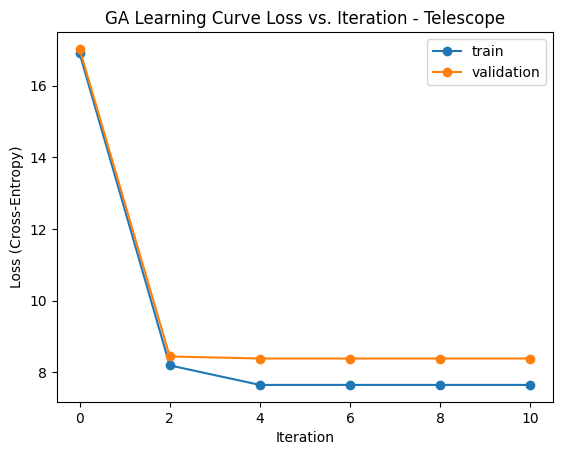

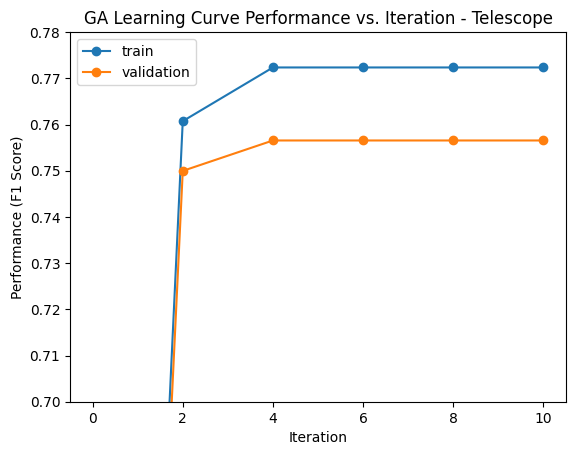

CPU times: user 532 ms, sys: 325 ms, total: 858 ms
Wall time: 174 ms


In [74]:
%%time
# ga_loss1, ga_f1_1 = mlrose_get_loss_per_iter(X1_train_train, y1_train_train, X1_val, y1_val, 
#                                              best_ga_params1)
plot_learning_curve_loss_iter(ga_loss1, model_type='GA', data_name=data1_name)
plot_learning_curve_f1_iter(ga_f1_1, ylim=(0.7,0.78), model_type='GA', data_name=data1_name)

## learning curve -- data percentage

100%|█████████████████████████████████████████████████████| 9/9 [11:16<00:00, 75.14s/it]


,f1_train,f1_val,train_pct
0,0.794509,0.728211,10
1,0.782485,0.714338,20
2,0.763758,0.741991,30
3,0.769790,0.750350,40
4,0.761525,0.739061,50
5,0.758135,0.758008,60
6,0.768338,0.758765,70
7,0.754461,0.749248,80
8,0.755045,0.729565,90


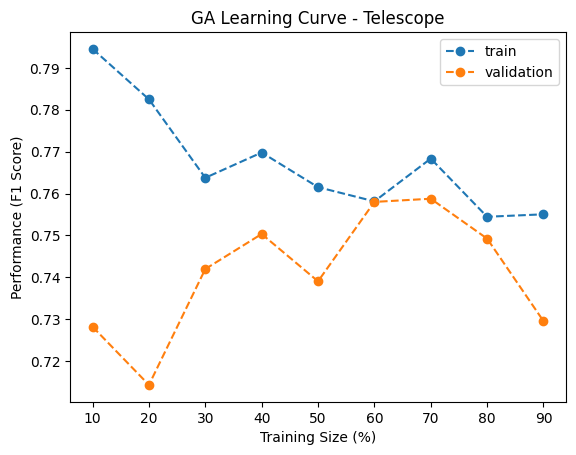

CPU times: user 55min 14s, sys: 7min 50s, total: 1h 3min 5s
Wall time: 11min 16s


In [66]:
%%time
ga_data_f1_1 = get_f1_score_vs_train_pct(X1_train, y1_train, **best_ga_params1)
plot_learning_curve(ga_data_f1_1, model_type='GA', data_name=data1_name)

## model performance

Test performance:
              precision    recall  f1-score   support

           0       0.76      0.71      0.74       147
           1       0.74      0.78      0.76       153

    accuracy                           0.75       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.75      0.75      0.75       300



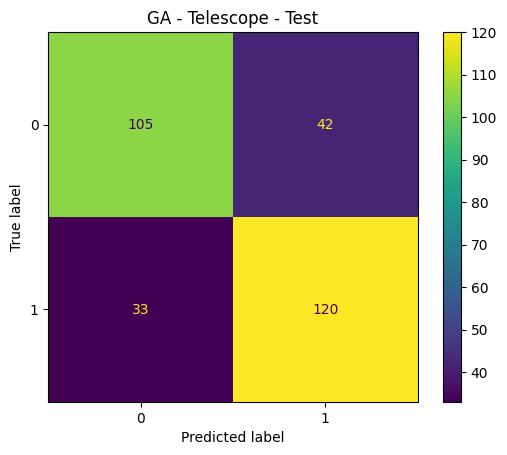

Train performance:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       343
           1       0.76      0.81      0.78       357

    accuracy                           0.77       700
   macro avg       0.77      0.77      0.77       700
weighted avg       0.77      0.77      0.77       700



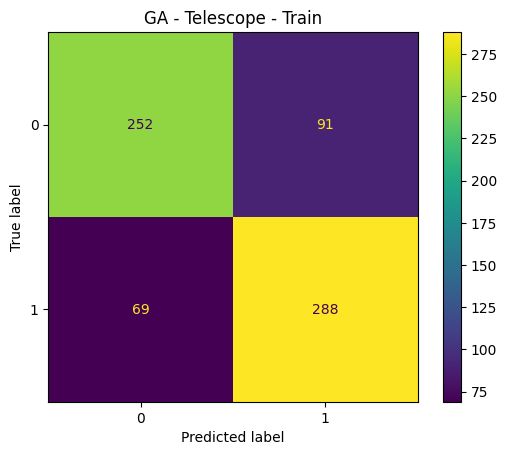

Train time is 26.2621 seconds.
Prediction time is 0.0001 seconds.


In [67]:
best_ga_classifier1 = mlrose.NeuralNetwork(**best_ga_params1, activation='relu', hidden_nodes=[20,20],
                                      bias=True, is_classifier=True, 
                                          early_stopping=True, max_attempts=20, curve=False, random_state=0)
ga_train_t1, ga_pred_t1 = model_performance(X1_train, y1_train, X1_test, y1_test, best_ga_classifier1, model_type='GA', 
                                                data_name=data1_name)

# comparison

In [68]:
labels = ['GD', 'RHC', 'SA', 'GA']

## time

In [72]:
rhc_train_t1

2754.4933

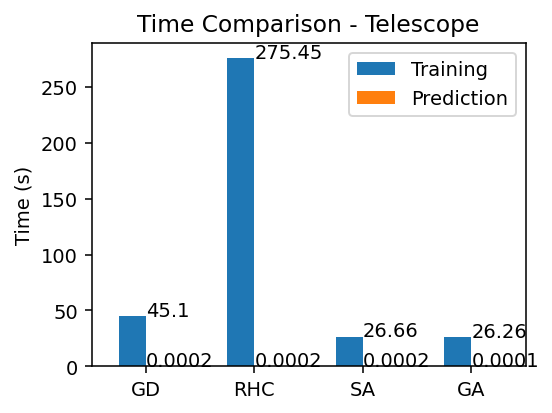

In [80]:
rhc_train_t0 = rhc_train_t1/10
train_t1 = [gd_train_t1, rhc_train_t0, sa_train_t1, ga_train_t1]
corr = 0.2
pred_t1 = [gd_pred_t1+corr, rhc_pred_t1+corr, sa_pred_t1+corr, ga_pred_t1+corr]
time_df1 = pd.DataFrame({'Training': train_t1, 'Prediction': pred_t1}, index=labels)
fig = plt.figure(figsize=(4,3), dpi=140)
axes = time_df1.plot.bar(rot=0, title=f'Time Comparison - {data1_name}', ax=plt.gca())
plt.ylabel('Time (s)')
for i,j in enumerate(train_t1):
    axes.annotate(str(round(j,2)),  xy=(i, j))
for i,j in enumerate(pred_t1):
    axes.annotate(str(round(j-corr,4)),  xy=(i, j))
plt.show()

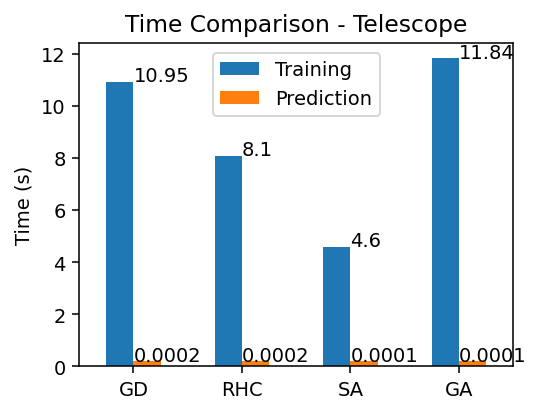

In [81]:
train_t1 = [gd_train_t1, rhc_train_t1, sa_train_t1, ga_train_t1]
corr = 0.2
pred_t1 = [gd_pred_t1+corr, rhc_pred_t1+corr, sa_pred_t1+corr, ga_pred_t1+corr]
time_df1 = pd.DataFrame({'Training': train_t1, 'Prediction': pred_t1}, index=labels)
fig = plt.figure(figsize=(4,3), dpi=140)
axes = time_df1.plot.bar(rot=0, title=f'Time Comparison - {data1_name}', ax=plt.gca())
plt.ylabel('Time (s)')
for i,j in enumerate(train_t1):
    axes.annotate(str(round(j,2)),  xy=(i, j))
for i,j in enumerate(pred_t1):
    axes.annotate(str(round(j-corr,4)),  xy=(i, j))
plt.show()

## F1 score

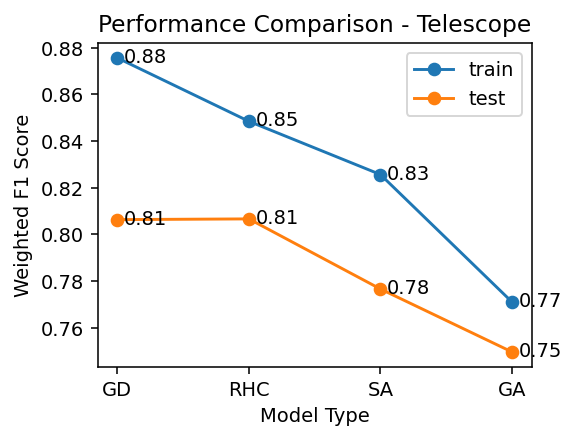

CPU times: user 1h 43min 56s, sys: 1min 35s, total: 1h 45min 32s
Wall time: 14min 53s


In [81]:
%%time
f1_train_ls1, f1_test_ls1 = all_model_f1_1(X1_train, y1_train, X1_test, y1_test)
fig, ax = plt.subplots(figsize=(4,3), dpi=140)
plt.plot(range(len(labels)), f1_train_ls1, 'o-', label='train')
plt.plot(range(len(labels)), f1_test_ls1, 'o-', label='test')
for i,j in enumerate(f1_train_ls1):
    ax.annotate(str(round(j,2)),  xy=(i+0.05, j-0.002))
for i,j in enumerate(f1_test_ls1):
    ax.annotate(str(round(j,2)),  xy=(i+0.05, j-0.002))
plt.xticks(range(len(labels)), labels)
plt.xlabel('Model Type')
plt.ylabel('Weighted F1 Score')
plt.legend()
plt.title(f'Performance Comparison - {data1_name}')
plt.show()

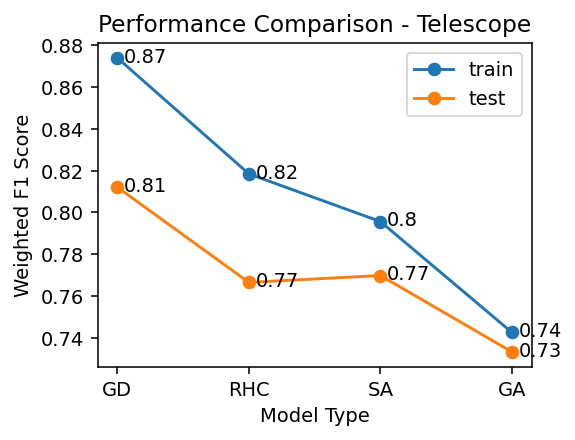

In [69]:
%%time
f1_train_ls1, f1_test_ls1 = all_model_f1_1(X1_train, y1_train, X1_test, y1_test)
fig, ax = plt.subplots(figsize=(4,3), dpi=140)
plt.plot(range(len(labels)), f1_train_ls1, 'o-', label='train')
plt.plot(range(len(labels)), f1_test_ls1, 'o-', label='test')
for i,j in enumerate(f1_train_ls1):
    ax.annotate(str(round(j,2)),  xy=(i+0.05, j-0.002))
for i,j in enumerate(f1_test_ls1):
    ax.annotate(str(round(j,2)),  xy=(i+0.05, j-0.002))
plt.xticks(range(len(labels)), labels)
plt.xlabel('Model Type')
plt.ylabel('Weighted F1 Score')
plt.legend()
plt.title(f'Performance Comparison - {data1_name}')
plt.show()